In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [16]:
import matplotlib as plt

In [20]:
import sys
import os

In [27]:
sys.path.append('/Users/krishnakalyan3/Educational/FastAI/fastai/')

In [28]:
from fastai.imports import *
from fastai.transforms import * 
from fastai.conv_learner import * 
from fastai.model import *
from fastai.dataset import * 
from fastai.sgdr import *
from fastai.plots import *

In [29]:
PATH = '../data/dogscats/'
size = 224

In [30]:
!ls {PATH}

models sample test1  train  valid


In [31]:
files = !ls {PATH}valid/cats | head 
files

['cat.1001.jpg',
 'cat.10016.jpg',
 'cat.10026.jpg',
 'cat.10048.jpg',
 'cat.10050.jpg',
 'cat.10064.jpg',
 'cat.10071.jpg',
 'cat.10091.jpg',
 'cat.10103.jpg',
 'cat.10104.jpg']

(499, 336, 3)

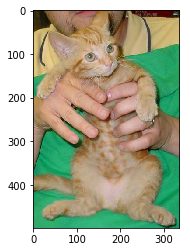

In [32]:
img = plt.imread(f'{PATH}valid/cats/{files[0]}')
plt.imshow(img);
img.shape

In [37]:
?tfms_from_model

In [44]:
arch = resnet34
data = ImageClassifierData.from_paths(PATH, tfms=tfms_from_model(f_model=resnet34,sz=size))
learn = ConvLearner.pretrained(arch, data, precompute=True) 
learn.fit(0.01, 3)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /Users/krishnakalyan3/.torch/models/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:18<00:00, 4611551.03it/s]


  2%|▏         | 6/360 [01:18<1:16:52, 13.03s/it]

Process Process-8:
Process Process-4:
Process Process-5:
Process Process-6:
Process Process-3:
Process Process-2:
Process Process-7:
Process Process-1:
Traceback (most recent call last):
  File "/usr/local/Cellar/python3/3.6.3/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/Cellar/python3/3.6.3/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/Cellar/python3/3.6.3/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/local/Cellar/python3/3.6.3/Frameworks/Pytho

KeyboardInterrupt: 

In [ ]:
data.val_y

In [ ]:
data.classes


In [ ]:
log_preds = learn.predict()
log_preds.shape

In [ ]:
log_preds[:10]

In [ ]:
preds = np.argmax(log_preds, axis=1)
probs = np.exp(log_preds[:,1])